In [1]:
import sys

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('./src')
from reproject_depthmap.depthmap_rendering import DepthmapRenderer
from reproject_depthmap.pinhole import PinholeCameraModel
from reproject_depthmap.io import read_f32

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### Load RGB

(1952, 2368, 3) uint8


Text(0.5, 1.0, 'Target image')

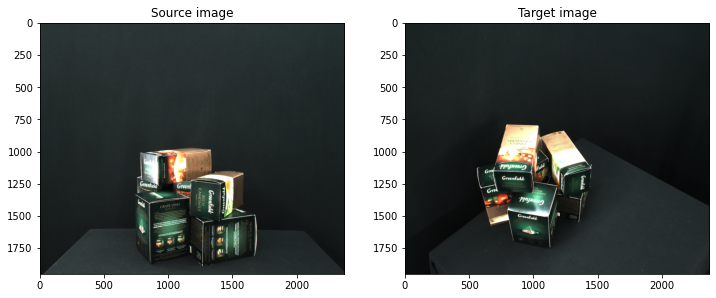

In [2]:
src_rgb = Image.open('./data/0000.png')
src_rgb = np.array(src_rgb)
print(src_rgb.shape, src_rgb.dtype)

tgt_rgb = Image.open('./data/0099.png')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(src_rgb); axes[0].set_title('Source image')
axes[1].imshow(tgt_rgb); axes[1].set_title('Target image')

#### Load depth map

Text(0.5, 1.0, 'Source depth map')

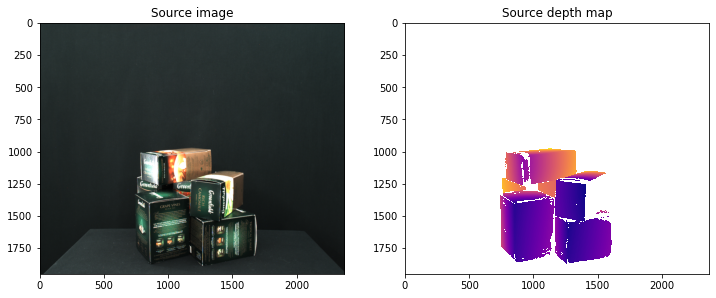

In [3]:
src_depth = read_f32('./data/0000_depth.png')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(src_rgb); axes[0].set_title('Source image')
axes[1].imshow(src_depth, cmap='plasma', interpolation='none'); axes[1].set_title('Source depth map')

#### Load camera models

In [4]:
"""Pinhole camera model,
   but you may use implement and use a different one, based on camera_model.CameraModel."""
src_cam_model = PinholeCameraModel(
    focal=[2316.6, 2318.8],
    principal=[1178.7, 978.8],
    size_wh=[2368, 1952]
)

'Same target camera model, but may be different.'
dst_cam_model = PinholeCameraModel(
    focal=[2316.6, 2318.8],
    principal=[1178.7, 978.8],
    size_wh=[2368, 1952]
)

#### Load camera poses

In [5]:
"""Camera-to-world transform matrix, with camera space defined as (as in COLMAP)
   X to the right, Y down, Z forward from the camera."""
src_c2w = np.loadtxt('./data/0000_c2w.txt')
tgt_c2w = np.loadtxt('./data/0099_c2w.txt')

#### Make mesh from depth map

In [6]:
src_depth = torch.as_tensor(src_depth)
src_c2w = torch.as_tensor(src_c2w).to(torch.float)

"""Triangles longer than the distance from the source camera to the triangle
   multiplied by `max_rel_edge_len` are culled during reprojection as false boundaries,
   corresponding to discontinuities in the depthmap.
   Set to infinity to not cull."""
max_rel_edge_len = 1e-2
# max_rel_edge_len = float('inf')

'Bolean mask representing source pixels with valid values.'
depth_is_valid = src_depth.isfinite()

'Any per-pixel attributes, which will be reprojected.'
attrs = torch.from_numpy(src_rgb).to(torch.float)

renderer = DepthmapRenderer(src_depth, depth_is_valid, src_cam_model, src_c2w, max_rel_edge_len, attrs)

<ipython-input-6-365ee261f61d>:1: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554793803/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  src_depth = torch.as_tensor(src_depth)


#### Reproject verts

In [7]:
tgt_c2w = torch.as_tensor(tgt_c2w).to(torch.float)

renderer.set_rays_from_camera(dst_cam_model)

c2w_t, c2w_rot = tgt_c2w[:3, 3], tgt_c2w[:3, :3]
render = renderer.render_to_camera(c2w_t, c2w_rot, ['z_depth', 'tri_ids', 'uv'], cull_back_faces=True)

Text(0.5, 1.0, 'Reprojected depth')

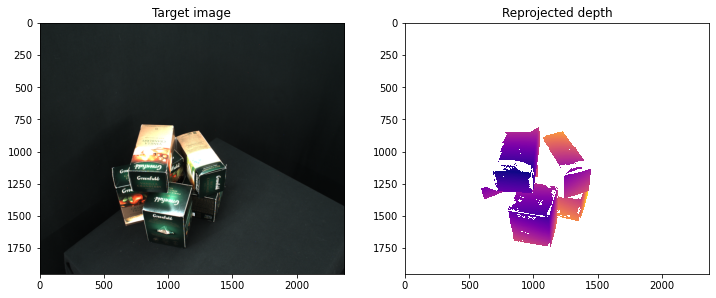

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(tgt_rgb); axes[0].set_title('Target image')
axes[1].imshow(render['z_depth'], cmap='plasma', interpolation='none'); axes[1].set_title('Reprojected depth')

#### Interpolate colors

In [9]:
repr_rgb = renderer.interpolate_to_camera(renderer.vert_attrs, render)

Text(0.5, 1.0, 'Reprojected image')

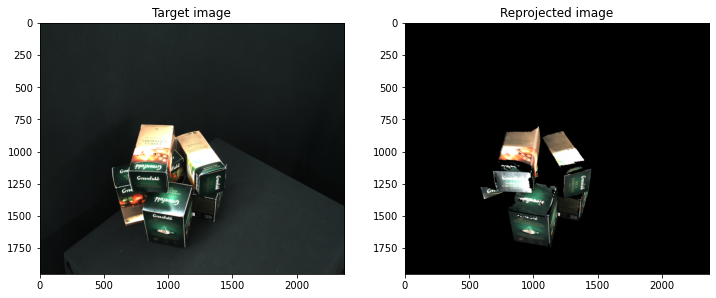

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(tgt_rgb); axes[0].set_title('Target image')
axes[1].imshow(repr_rgb.round().byte()); axes[1].set_title('Reprojected image')